# ***Apprendre les habitudes de travail de Seattle à partir du nombre de vélos***  
   
plutôt que de faire des hypothèses afin de construire des modèles qui pourraient décrire les données, je vais plutôt nettoyer l'ardoise et demander quelles informations nous pouvons extraire des données elles-mêmes, sans confiance. sur toutes les hypothèses du modèle. Cet article examinera les données à l'aide d'une approche d'apprentissage non supervisé pour l'exploration des données .  
  
Nous verrons également des exemples concrets de l'utilisation d'algorithmes d'apprentissage automatique non supervisés, tels que l'analyse des composants principaux et les modèles de mélange gaussien, pour explorer et extraire du sens des données.
   


In [1]:
import pandas as pd

data = pd.read_csv('/content/Fremont_Bridge_Bicycle_Counter.csv', 
                   index_col='Date', parse_dates=True)

data.head()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2019-11-01 00:00:00,12.0,7.0,5.0
2019-11-01 01:00:00,7.0,0.0,7.0
2019-11-01 02:00:00,1.0,0.0,1.0
2019-11-01 03:00:00,6.0,6.0,0.0
2019-11-01 04:00:00,6.0,5.0,1.0


Nous allons effectuer un nettoyage rapide des données: Nous allons renommer les colonnes en "West" et "East", et nous allons définir les valeurs manquantes sur zéros.

In [2]:
data.columns = ['Total', 'East', 'West']
data.fillna(0, inplace=True)

In [3]:
data.head()

,Total,East,West
Date,,,
2019-11-01 00:00:00,12.0,7.0,5.0
2019-11-01 01:00:00,7.0,0.0,7.0
2019-11-01 02:00:00,1.0,0.0,1.0
2019-11-01 03:00:00,6.0,6.0,0.0
2019-11-01 04:00:00,6.0,5.0,1.0


Nous pouvons avoir une meilleur idée de l'ensemble de données dans son ensemble grâce à une simple visualisation; par exemple, nous pouvons ré-échantilloner les données pour voir la tendance hebdomadaire des déplacements sur la période de près de trois ans:

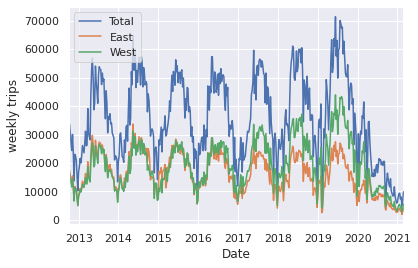

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()  # plot styling

data.resample('W').sum().plot()
plt.ylabel('weekly trips');


Les dénombrements montrent à la fois une forte variation saisonnière et une structure locale qui peut être *partiellement expliquée* par la température, la période de l'année, les précipitations et d'autres facteurs.  

## ***Extraire des connaissances à partir des données***  

À partir de là, nous pourrions faire une variété d'autres visualisations basées sur notre intuition sur ce qui pourrait affecter le nombre de vélos. Par exemple, nous pourrions examiner l'effet des jours de la semaine, l'effet de la météo et d'autres facteurs que j'ai explorés précédemment . Mais nous pourrions également continuer en laissant l'ensemble de données parler de lui-même et utiliser des techniques d' apprentissage automatique non supervisées (c'est-à-dire l'apprentissage automatique sans référence aux étiquettes de données) pour apprendre ce que les données ont à nous dire.

Nous considérerons chaque jour dans l'ensemble de données comme sa propre entité distincte (ou échantillon , dans le langage habituel de l'apprentissage automatique). Pour chaque jour, nous avons 48 observations: deux observations (capteurs de trottoir est et ouest) pour chacune des périodes de 24 heures. En examinant les jours à la lumière de ces observations et en effectuant une analyse minutieuse, nous devrions être en mesure d'extraire des déclarations quantitatives significatives à partir des données elles-mêmes, sans avoir besoin de s'appuyer sur d'autres hypothèses.

### ***Transformer les donnnées***  
   
La première étape de cette approche est de transformer nos données; essentiellement nous voudrons une matrice bidemensionnelle, où chaque ligne de la matrice correspond à un jour, et chaque colonne de la matrice correspond à l'une des 48 observations. Nous pouvons organiser les données de cette manières en utilisant la `pivot_table()` fonction dans pandas. Nous voulons les valeurs des colonnes "EAST" et "WEST", indexées par date et séparées par heure de la journée. Toutes les valeurs manquantes ue nous remplirons avec zéros:

In [5]:
pivoted = data.pivot_table(['East','West'],
                           index=data.index.date,
                           columns=data.index.hour,
                           fill_value=0)
pivoted.head()

East                             ... West                               
Date         0   1  2  3  4   5    6    7   ...   16   17   18   19  20  21  22  23
2012-10-03    4   4  1  2  6  21  105  257  ...  182  391  258   69  51  38  25  12
2012-10-04    7   3  3  0  7  15   91  230  ...  161  353  241  107  56  39  21  30
2012-10-05    4   4  4  2  7  18   68  218  ...  190  290  209   73  41  31  26  16
2012-10-06    8  10  7  1  4   3   12   17  ...   76   73   55   38  18  15  20  19
2012-10-07    6  12  2  4  1   6    9   14  ...   93   73   45   23  36  35   9  11

[5 rows x 48 columns]

Ensuite, nous extrayons les valeurs brutes et les mettre dans une matrice:

In [6]:
X = pivoted.values
X.shape

(3071, 48)

Nos données se composent d'un peu plus de 3000 jours, chacun avec les 48 measures susmentionnées.

### ***Visualiser les données***  

Nous pouvons maintenant considérer ces données comme représentant 3071 objets distincts qui vivent dans un espace de 48 dimensions: la valeur de chaque dimension est le nombre de déplacements à vélo mesurés sur un côté particulier du pont à une heure donnée. La visualisation de données en 48 dimensions est assez difficile, nous allons donc utiliser à la place une technique de *réduction de dimensionnalité standard* pour projeter cela à une taille plus gérable.  

La technique que nous utiliserons est *l'analyse en composantes principales(ACP)*, une projection linéaire rapide qui fait pivoter les données de telles sorte que la projection préserve la variance maximale. On peut demander des composants préservant 90% de la variance comme suit:  


In [7]:
from sklearn.decomposition import PCA

Xpca = PCA(0.9).fit_transform(X)
Xcompo = PCA(0.8).fit_transform(X)
Xpca.shape
Xcompo.shape

(3071, 2)

La sortie à trois dimensions, ce qui signifie que ces deux composantes projetées décrivent au moins 90% de la vriance totale dans l'ensemble de données. Bien que les données en 48 dimensions soient difficiles à tracer, nous savons certainement comment tracer des données en deux dimensions: nous ferons un simple nuage de points, et pour référence, nous colorerons chauque point en fonction du nombre total de voyage effectué ce jour-là

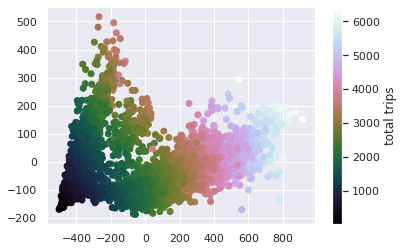

In [8]:
total_trips = X.sum(1)
plt.scatter(Xcompo[:, 0], Xcompo[:, 1], c=total_trips, cmap='cubehelix')

plt.colorbar(label='total trips')

On voit que les jours se trouvent dans deux goupes bien distincts et que le nombre total de vouges auguemente le long de la longueur de chaque groupe projetée. De plus, les deux groupes commencent à être moins distingués lorsque le nombre de voyages pendant la journée est très faible.  
   
Je trouve cela extrêmement intéressant: à partir des données brutes, nous pouvons déterminer qu'il existe essentiellement deux types principaux de jours pour les cyclistes de seattle. Modélisons ces clusters et essayons de comprendre ce que sont ces types de journée. 

### ***Clustering non Supervisé***  
   
Lorsque vous avez des groupes de données que vous séparer automatiquement, mais pas d'étiquettes préalablement déterminées pour les groupes, le type d'algorithme quee vous recherchez est un algorithme de *clustering*. Il existe un certain nombre d'algorithmes de clustering, mais pour les blobs de forme ovale bien définis comme nous le voyons ci-dessus, les modèles de mélange gaussien sont un très bon choix. Nous pouvons calculer le modèle de mélange gaussien des données en utilisant, encore une fois, scikit_learn, et tracer rapidement les étiquettes prédites pour les points: 

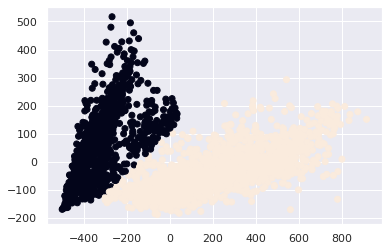

In [9]:
from sklearn.mixture import  GaussianMixture
gmm =  GaussianMixture(2, covariance_type='full', random_state=0)
gmm.fit(Xcompo)
cluster_label = gmm.predict(Xcompo)
plt.scatter(Xcompo[:, 0], Xcompo[:, 1], c=cluster_label);

Ce clustering semble avoir fait le travail et séparé les deux groupes qui nous intéressent. Joignons ces étiquettes de cluster inférées à l'ensemble de données initial:

In [10]:
pivoted.head

<bound method NDFrame.head of            East                             ... West                               
Date         0   1  2  3  4   5    6    7   ...   16   17   18   19  20  21  22  23
2012-10-03    4   4  1  2  6  21  105  257  ...  182  391  258   69  51  38  25  12
2012-10-04    7   3  3  0  7  15   91  230  ...  161  353  241  107  56  39  21  30
2012-10-05    4   4  4  2  7  18   68  218  ...  190  290  209   73  41  31  26  16
2012-10-06    8  10  7  1  4   3   12   17  ...   76   73   55   38  18  15  20  19
2012-10-07    6  12  2  4  1   6    9   14  ...   93   73   45   23  36  35   9  11
...         ...  .. .. .. ..  ..  ...  ...  ...  ...  ...  ...  ...  ..  ..  ..  ..
2021-02-24    1   1  0  0  1   6   12   47  ...  101  152   71   31  36  16  11   4
2021-02-25    0   2  0  1  3   4    6   37  ...   52   88   57   32  11   4   8   5
2021-02-26    0   0  0  1  1   6   21   25  ...   88   99   56   42  15   6   4   3
2021-02-27    0   1  0  0  0   3    6   17  ..

In [11]:
pivoted['Cluster'] = cluster_label
data = data.join(pivoted['Cluster'], on=data.index.date)
data.head()

,Total,East,West,Cluster
Date,,,,
2019-11-01 00:00:00,12.0,7.0,5.0,1
2019-11-01 01:00:00,7.0,0.0,7.0,1
2019-11-01 02:00:00,1.0,0.0,1.0,1
2019-11-01 03:00:00,6.0,6.0,0.0,1
2019-11-01 04:00:00,6.0,5.0,1.0,1


Nous pouvons maintenant trouver la tendance moyenne par cluster et par heure à l'aide d'un GroupeBy dans cet ensemble de données mis à jour

In [12]:
by_hour = data.groupby(['Cluster', data.index.time]).mean()
by_hour.head()

Total      East      West
Cluster                                        
0       00:00:00  13.499079  5.592081  7.906998
        01:00:00   7.763352  3.450276  4.313076
        02:00:00   5.034530  2.351289  2.683241
        03:00:00   2.954420  1.459945  1.494475
        04:00:00   3.846685  1.663904  2.182781

Enfin, nous pouvons tracer la tendance horaire moyenne parmi les jours de chaque cluster

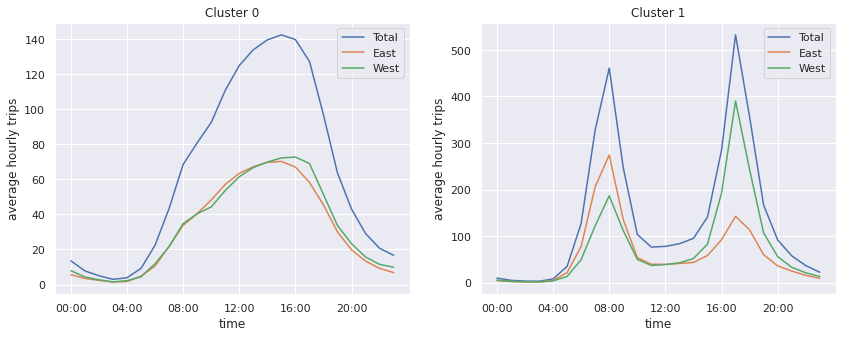

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
hourly_ticks = 4 * 60 * 60 * np.arange(6)

for i in range(2):
    by_hour.loc[i].plot(ax=ax[i], xticks=hourly_ticks)
    ax[i].set_title('Cluster {0}'.format(i))
    ax[i].set_ylabel('average hourly trips')

Ces graphiques nous donnent un aperçu de l'interprétation des deux groupes: le premier groupe montre un modèle de trafic bimodal net, tandis que le second montre un modèle unimodal large.  
  
Dans le groupe bimodal, nous voyons un pic vers 8h00 qui est dominé par les cyclistes sur le trotoir ouest, et un autre pic vers 17h00 qui est dominé par les cyclistes sur le trottoir est. Il s'agit clairemnt d'un modèle de trajet domicile-travail, la majorité des cyclistes se dirigeant vers le centre-ville de Seattle le matin et s'éloignant du centre-ville de Seattle le soir.  

Dans le cluster unimodal, nous voyons un trafic assez régulier dans chaque direction commençant tôt le matin et allant jusque tard dans la nuit, avec un pic vers 2 heures de l'après-midi. Il s'agit clairement d'un mode d'utilisation récréatif, avec des gens qui roulent toute la journée.  
  

Je trouve cela fascinant:à partir d'une simple réduction de dimensionnalité et de regroupement non supervisés, nous avons découvert deux classes distinctes de jours dans les données et constaté que ces classes ont des explications très intuitives.  



## ***Habitudes de travail de Seattle***  
  
Allons un peu plus loin et découvrons ce que nous pouvons apprendre sur les gens(enfin, les cyclistes) à Seattle à partir de ces données horaires. À titre d'approximation approximative, on peut supposer que ces deux classes de données pourraient refléter en grande partie les jours de travail dans le premier groupe et les jours sans travail dans le second. Nous pouvons vérifier cette intuition en redessinant nos données projetées, sauf en les étiquetant par jour de la semaine:


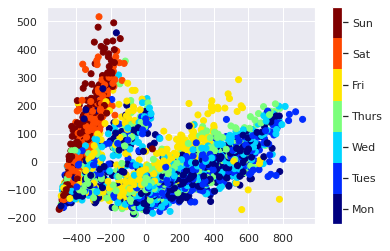

In [14]:
dayofweek = pd.to_datetime(pivoted.index).dayofweek
plt.scatter(Xpca[:, 0], Xpca[:,1], c=dayofweek,
            cmap=plt.cm.get_cmap('jet', 7))
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.clim(-0.5, 6.5)

Nous voyons que l'intuition jour de semaine/week-end tient, mais seulement jusqu'à un certain point: en particulier, il est clair qu'il **y a une poignée de jour de la semaine qui suivent le modèle typique du week-end!** En outre, il est intéressant de noter que les vendredis ont tendance à être rapprochés des jours de week-end dans cette parcelle, bien que dans l'ensemble, il tombent toujours solidement dans le groupe des jours de travail.  
  

Examinons de plus près les jours de semaine "spéciaux" qui appartiennent au "mauvais" cluster. Nous commençons par construire un ensemble de données répertoriant l'id du cluster et le jour de la semaine pour chacune des dates de notre ensemble de données:
   


In [15]:
results = pd.DataFrame({'cluster': cluster_label,
                        'is_weekend': (dayofweek > 4),
                        'weekday': pivoted.index.map(lambda x: x.strftime('%a'))},
                       index = pivoted.index)

results.head()

,cluster,is_weekend,weekday
2012-10-03,1,False,Wed
2012-10-04,1,False,Thu
2012-10-05,1,False,Fri
2012-10-06,0,True,Sat
2012-10-07,0,True,Sun


Tout d'abord, voyons combien de jours de week-end tombent dans le premier cluster axé sur les trajets domicile-travail

In [16]:
weekend_workdays = results.query('cluster == 0 and is_weekend')
len(weekend_workdays)

877

877!! Apparemment, il y'a beaucoup de week-end au cour de ces année où les cyclistes de Seattle dans leur ensemble décident d'aller travailler.  
  
De même, nous pouvons voir combien de jours de la semaine tombent dans le deuxième cluster, axé sur les loisir:

In [17]:
midweek_holidays = results.query('cluster == 1 and not is_weekend')
len(midweek_holidays)

1829

Il y a eu 1829 jours de semaine au cours des dernières années pendant lesquels les cyclistes de Seattle dans leur ensemble ne se sont pas rendus au travail. Pour les étiqueter, chargeons le calendrier des jours fériés fédéral américain disponible dans Pandas

In [18]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2019', return_name=True)
holidays.head()

2012-01-02                 New Years Day
2012-01-16    Martin Luther King Jr. Day
2012-02-20                Presidents Day
2012-05-28                  Memorial Day
2012-07-04                      July 4th
dtype: object

Par souci d'exhaustivité, nous ajouterons à la liste la veille et le lendemain de chacun de ces jours fériés:

In [19]:
holidays_all = pd.concat([holidays,
                          "Day Before" + holidays.shift(-1,'D'),
                          "Day After" + holidays.shift(1, 'D')])

holidays_all = holidays_all.sort_index()
holidays_all.head()

2012-01-01                 Day BeforeNew Years Day
2012-01-02                           New Years Day
2012-01-03                  Day AfterNew Years Day
2012-01-15    Day BeforeMartin Luther King Jr. Day
2012-01-16              Martin Luther King Jr. Day
dtype: object

Notez que ce sont des jours fériés observés, c'est pourquoi le Nouvel An 2012 tombe le 2 janvier. Avec cela prêt à l'emploi, nous pouvons calculer la liste complète des jours hors week-end pendant lesuels les cyclistes de Seattle dans leur ensemble ont choisi de rester à la maison après le travail:

In [20]:
holidays_all.name = 'name'  # required for join
joined = midweek_holidays.join(holidays_all)
set(joined['name'])

{'Columbus Day',
 'Day AfterColumbus Day',
 'Day AfterJuly 4th',
 'Day AfterLabor Day',
 'Day AfterMartin Luther King Jr. Day',
 'Day AfterMemorial Day',
 'Day AfterNew Years Day',
 'Day AfterPresidents Day',
 'Day AfterVeterans Day',
 'Day BeforeJuly 4th',
 'Day BeforeThanksgiving',
 'Day BeforeVeterans Day',
 'Martin Luther King Jr. Day',
 'Presidents Day',
 'Veterans Day',
 nan}

De l'autre côté des choses, voici les jours fériés reconnus par le gouvernement fédéral où les cyclistes de Seattle ont quand même choisi d'aller travailler:

In [21]:
set(holidays) - set(joined.name)

{'Christmas',
 'July 4th',
 'Labor Day',
 'Memorial Day',
 'New Years Day',
 'Thanksgiving'}

## ***Mise à jour: que se passe-t-il avec les vendredis ?***  
   
Un de mes collègues, Ariel Rokem, a vu la première version de ce post et a remarqué quelque chose d'intéressant. Pour la plupart, les vendredi ont tendance à se situer sur le côté supérieur de la graphe de la semaine, plus près dans cet espace de paramètres du modèle de week-end typique. Ce modèle est presque universel pour les vendredis, tous sauf trois étranges valeurs aberrantes qui se trouvent loin de l'autre côté de la graphe.  
   
Nous pouvons les voir plus clairement si nous mettons en évidence les points du vendredi dans l'intrigue:

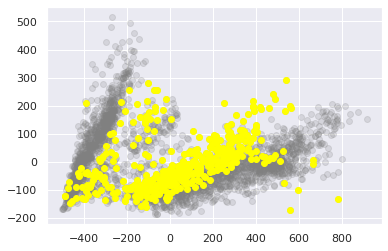

In [22]:
fridays = (dayofweek==4)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[fridays, 0], Xpca[fridays, 1], c='yellow')

Les points jaunes en bas à gauche de l'intrigue sont uniques-ils sont très différents des autres vendredis, et ils se démarquent même des jours de travail! Voyons ce qu'ils représentent:

In [32]:
weird_fridays = pivoted.index[fridays & (Xpca[:, 0] < -470)]
weird_fridays

Index([2015-12-25, 2020-12-25, 2021-01-01], dtype='object')

Ces trois vendredis périphériues tombent à la fin decembre. Curieuse!!  
  
  
Visualisation rapidement les statistiques quotidiennes de ces derniers, ainsi que la tendance moyenne sur tous les jours. Nous pouvons organiser les données de cette façon avec une opération de tableau croisé dynamique:

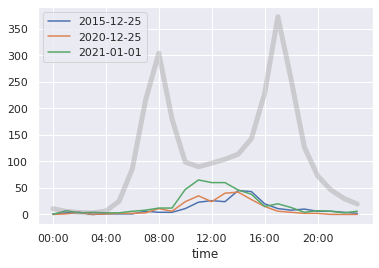

In [33]:
all_days = data.pivot_table('Total', index=data.index.time, columns=data.index.date)
all_days.loc[:, weird_fridays].plot();
all_days.mean(1).plot(color='gray', lw=5, alpha=0.3,
                      xticks=hourly_ticks);

Apparemment, ces trois vendredis étranges sont des jours où les déplacements à vélo sont extrêmement fréquents . Mais qu'est-ce qui les rend si spéciaux?

Après quelques fouilles sur Internet, la réponse devient claire: nous avons découvert la journée annuelle du vélo au travail à Seattle . Mystère résolu!

## ***Résumé***  
Nous avons vu ici qu'en examinant de près le nombre de vélos bruts et en utilisant une visualisation de base et un apprentissage automatique non supervisé, nous pouvons faire des déclarations très précises sur les habitudes de travail générales des personnes à Seattle qui se rendent au travail à vélo sur le pont Fremont. En résumé, voici ce que nous avons appris:  
* Les cyclistes de Seattle, dans leur ensemble, ont tendance à décoller du travail le jour de l'an, le jour du souvenir, le jour de l'indépendance, la fête du travail et les jours de Thanksgivings et de Noël.  
* Les cyclistes de Seattle, dans leur ensemble, ont tendance à se rendre au bureau lors des jours fériés les plus mineurs aux Etats-Units:Columbus Day, Martin Luther King Jr.Day, Presidents Day et Veterans Day.  
* Les cyclistes de Seattle, dans leur ensemble, ne seraient jamais, jamais, surpris au travail un week-end.  
